# Week 10 Practical - Question 2 Solution
## Multi-Task Learning with Siamese Networks

Siamese networks can also be configured for multi-task learning. There are many ways to do this, but a common way is to consider a secondary task on one of the inputs. Using the Week 7 practical solution as a starting point, add a second task to the network. Possible tasks include:
* A classification output, which uses the embedding from one image (such as the anchor image) to classify the face into the identity using a softmax output.
* An image output, that adds a decoder to the embedding to try and reconstruct the original image.	

For both of these, you may also wish to consider appropriate loss weights. Any selection of loss weights should consider both the importance of the tasks, and also the scale of the losses (i.e. are both losses typically in the same range? Or is one much larger or smaller than the other?).

Using the modified network, evaluate the face recognition performance on YaleB, ORL and Yale. As with Question 1, use a simple classifier and feel free to borrow from code such as the week 7 practical solutions. Compare the generalisation ability of the multi-task network to the original single task network.

## Our Approach

In this solution we'll look at the autoencoder output option. The first solution (2a) will look at the first option.

In [1]:
import os
# why is this here? This is disabling some tensorflow warning I get in some of my environments that 
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import random
import numpy
import numpy.matlib
import scipy
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay

# for consistency
random.seed(4)

## Code Reuse

This solution is going to make heavy use of code from previous examples. In particular:
* The Week 7 practical solution, which used the face rec datasets with a triplet network. The data loading, network structure, face rec classifier training and evaluation is taken from here. Really, we're just adding a second task to this network
* The 2a practical solution for this week. In fact, this solution is VERY similar to that one.

Given the heavy code reuse, commentary with this solution will be somewhat sparse, and will focus on the new bits.

## Data Loading

As per the 2a solution.

In [2]:
yale_b = scipy.io.loadmat('../../data/YaleB_32x32.mat')
fea = yale_b['fea'] / 255.0
gnd = numpy.array(yale_b['gnd'])

test_frames = numpy.array(()).astype('int')
for i in numpy.unique(gnd):    
    indexes = numpy.where(gnd == i)[0]
    count = len(indexes);
    f = numpy.random.randint(count, size=6)
    test_frames = numpy.append(test_frames, indexes[f])

train_fea = fea
train_gnd = gnd
train_fea = numpy.delete(train_fea, test_frames, 0)
train_gnd = numpy.delete(train_gnd, test_frames, 0)
test_fea = fea[test_frames, :]
test_gnd = gnd[test_frames, :]
train_gnd = numpy.reshape(train_gnd, -1)
test_gnd = numpy.reshape(test_gnd, -1)

train_fea_reshape = numpy.reshape(train_fea.transpose(), (32, 32, 1, len(train_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_fea.transpose(), (32, 32, 1, len(test_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

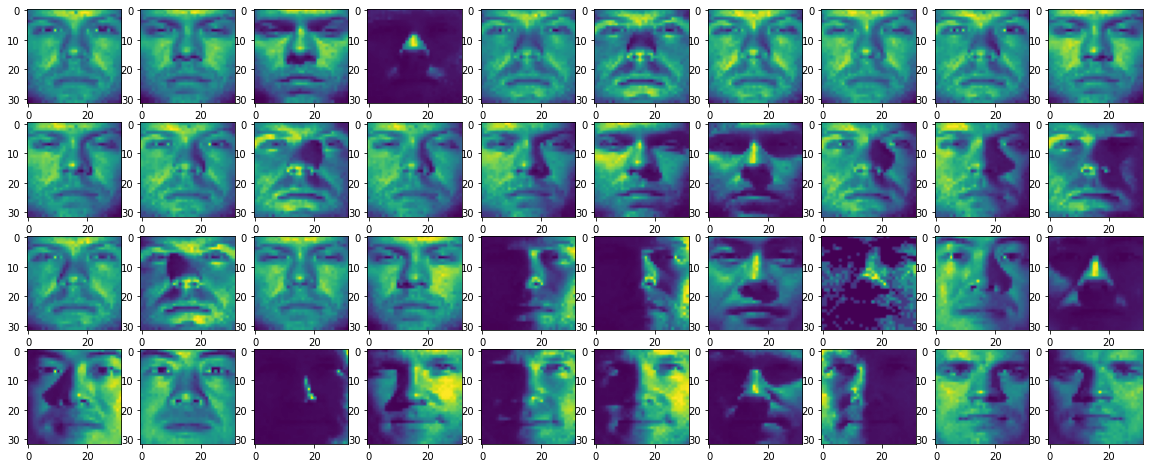

In [3]:
fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])    

## Data Extraction Functions

Largely from the Week 7 practical solution, however we're also getting an auto-encoder output from the triplet generation, which is just the anchor image again.

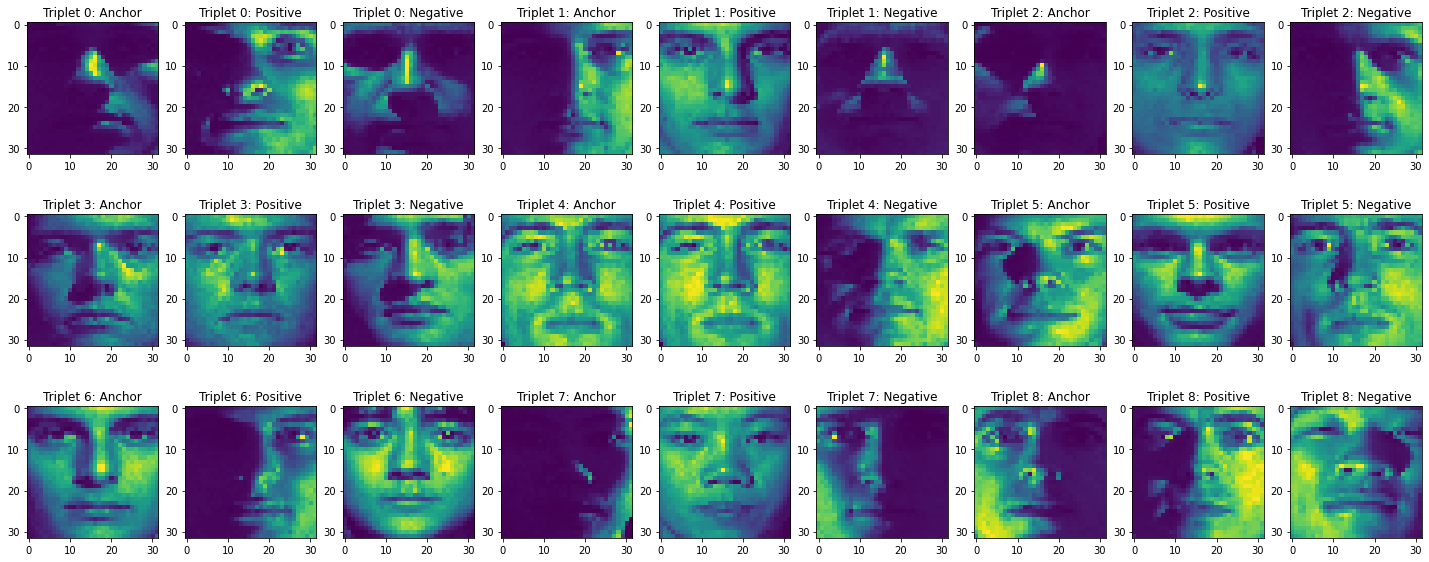

In [4]:
def GetSiameseData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    label = numpy.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def GetTripletData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_c = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    out_labels = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
        
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

        out_labels[i, :, :, :] = imgs[idx1,:,:,:]

    return [image_a, image_b, image_c], out_labels

def TripleGenerator(imgs, labels, batch_size):
    while True:
        [image_a, image_b, image_c], out_labels = GetTripletData(imgs, labels, batch_size)
        yield [image_a, image_b, image_c], [out_labels]
        
test = TripleGenerator(train_fea_reshape, train_gnd, 9)
x, anchor_labels = next(test)

fig = plt.figure(figsize=[25, 10])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Triplet ' + str(i) + ': Anchor')
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Triplet ' + str(i) + ': Positive')

    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])    
    ax.set_title('Triplet ' + str(i) + ': Negative')        

In [5]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

## The Network

Here's where we actually diverge slightly. We'll add a decoder now to the anchor embedding, and use this to try and reconstruct the original input. Note that this is perhaps not optimal (for example, a U-Net style network as per week 10 would probably be far better).

In [6]:
embedding_size = 32
dummy_input = keras.Input((32, 32, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')

class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = K.l2_normalize(anchor, axis=1)
        positive = K.l2_normalize(positive, axis=1)
        negative = K.l2_normalize(negative, axis=1)

        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
input_anchor = keras.Input((32, 32, 1), name='Anchor')
input_positive = keras.Input((32, 32, 1), name='Positive')
input_negative = keras.Input((32, 32, 1), name='Negative')

embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

margin = 1

decoder = layers.Dense(64, activation='relu')(embedding_anchor)
decoder = layers.Reshape((4, 4, 4))(decoder)
decoder = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(decoder)
decoder = layers.UpSampling2D((2, 2))(decoder)
decoder = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(decoder)
decoder = layers.UpSampling2D((2, 2))(decoder)
decoder = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoder)
decoder = layers.UpSampling2D((2, 2))(decoder)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='autoenc_output')(decoder)

triplet_loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')(
    [embedding_anchor, embedding_positive, embedding_negative])

In [7]:
triplet_network = keras.Model(inputs=[input_anchor, input_positive, input_negative], 
                              outputs=[decoded, triplet_loss_layer])
triplet_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor (InputLayer)             [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
SiameseBranch (Functional)      (None, 32)           552056      Anchor[0][0]                     
                                                                 Positive[0][0]                   
                                                                 Negative[0][0]                   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        SiameseBranch[0][0]              
______________________________________________________________________________________________

We have some loss weights going on here. My loss weight for the MSE (autoencoder) is so huge because:
* this loss naturally produces tiny values, while the triplet loss produces quite big values (especially early in training)
* to try and encourage the network to learn a more general representation, but focusing on the more general task

In [8]:
triplet_network.compile(optimizer=keras.optimizers.RMSprop(), loss=['mse', None], loss_weights=[10000, 1])

batch_size = 128
triplet_train_x, train_labels = GetTripletData(train_fea_reshape, train_gnd, 
                                               20000)
triplet_test_x, test_labels = GetTripletData(test_fea_reshape, test_gnd, 
                                             1000)

triplet_network.fit(triplet_train_x, train_labels, batch_size=128, epochs=20, 
                    validation_data=(triplet_test_x, test_labels))

Epoch 1/20
157/157 [==============================] - 27s 126ms/step - loss: 355.6211 - autoenc_output_loss: 0.0239 - val_loss: 293.0233 - val_autoenc_output_loss: 0.0190
Epoch 2/20
157/157 [==============================] - 17s 106ms/step - loss: 245.9211 - autoenc_output_loss: 0.0156 - val_loss: 244.9939 - val_autoenc_output_loss: 0.0178
Epoch 3/20
157/157 [==============================] - 17s 106ms/step - loss: 197.6653 - autoenc_output_loss: 0.0140 - val_loss: 165.6925 - val_autoenc_output_loss: 0.0123
Epoch 4/20
157/157 [==============================] - 22s 138ms/step - loss: 166.9497 - autoenc_output_loss: 0.0129 - val_loss: 254.0953 - val_autoenc_output_loss: 0.0222
Epoch 5/20
157/157 [==============================] - 22s 142ms/step - loss: 152.3909 - autoenc_output_loss: 0.0124 - val_loss: 186.4477 - val_autoenc_output_loss: 0.0158
Epoch 6/20
157/157 [==============================] - 23s 147ms/step - loss: 140.9330 - autoenc_output_loss: 0.0117 - val_loss: 155.1280 - val_au

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


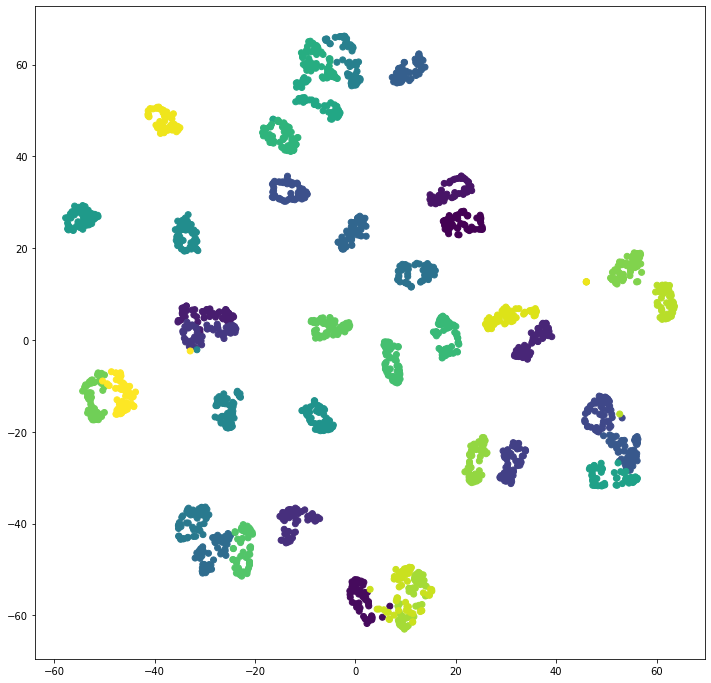

In [9]:
embeddings = base_network.predict(train_fea_reshape)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_gnd.flatten());

Our t-SNE embeddings look a bit different now, with the plot no where near as tightly grouped as we've seen before.

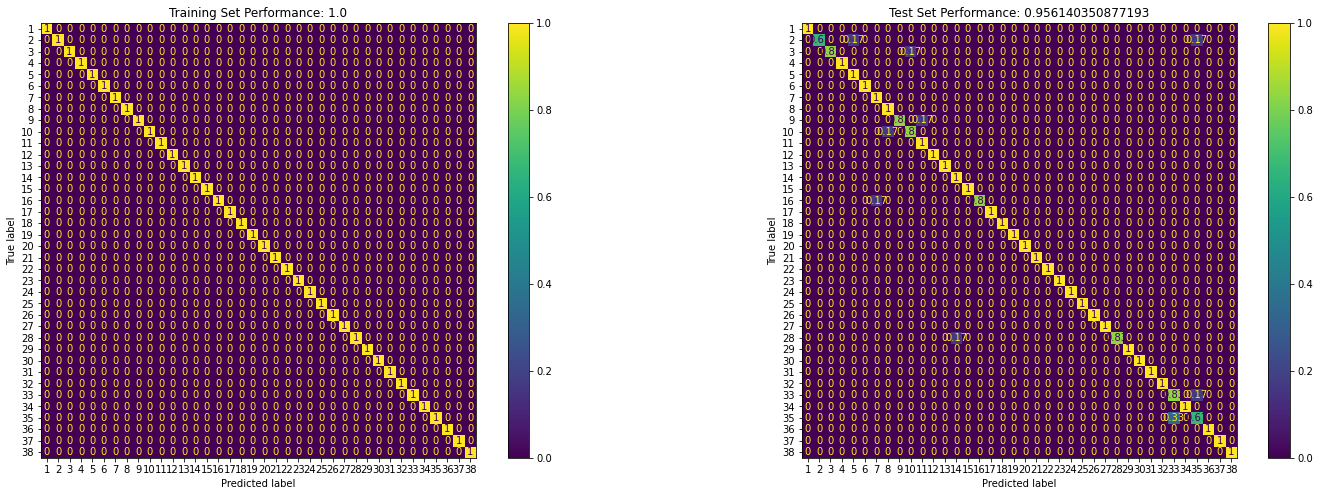

In [10]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: %s' % (sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Test Set Performance: %s' % (sum(pred == Y_test)/len(Y_test)));  
    
test_embeddings = base_network.predict(test_fea_reshape)
cknn_siam = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn_siam.fit(embeddings, train_gnd)
eval_model(cknn_siam, embeddings, train_gnd, test_embeddings, test_gnd) 

Results on YaleB are slightly worse, but still pretty good really.

## Generalisation

On ORL now.

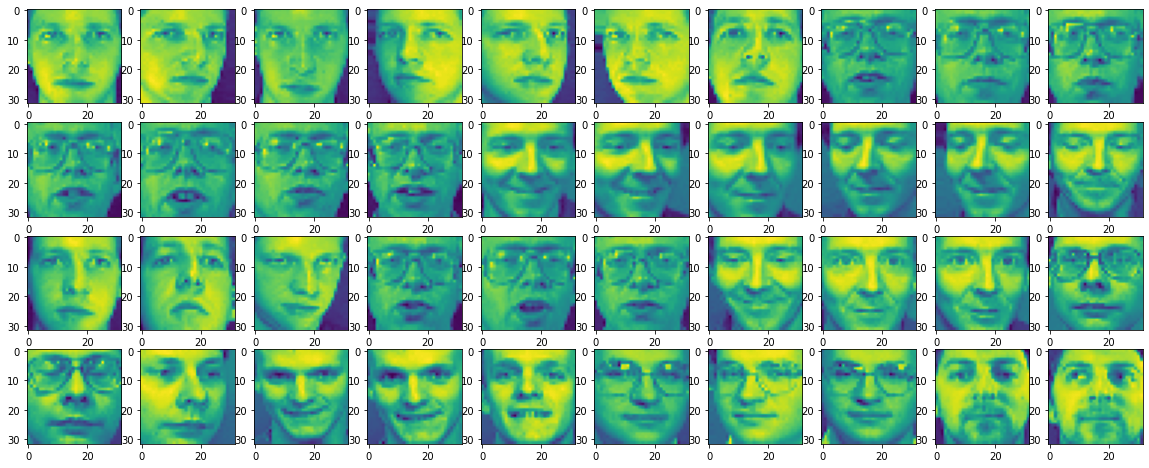

In [11]:
orl = scipy.io.loadmat('../../data/ORL_32x32.mat');
fea = orl['fea'] / 255.0
gnd = numpy.array(orl['gnd'])

train_frames = []
for i in range(40):
    for j in range(7):
        train_frames.append(i*10 + j)
        
train_orl_fea = fea[train_frames, :]
train_orl_gnd = gnd[train_frames, :]
test_orl_fea = fea
test_orl_gnd = gnd
test_orl_fea = numpy.delete(test_orl_fea, train_frames, 0)
test_orl_gnd = numpy.delete(test_orl_gnd, train_frames, 0)
train_orl_gnd = numpy.reshape(train_orl_gnd, -1)
test_orl_gnd = numpy.reshape(test_orl_gnd, -1)

train_fea_reshape = numpy.reshape(train_orl_fea.transpose(), (32, 32, 1, len(train_orl_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_orl_fea.transpose(), (32, 32, 1, len(test_orl_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])    

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


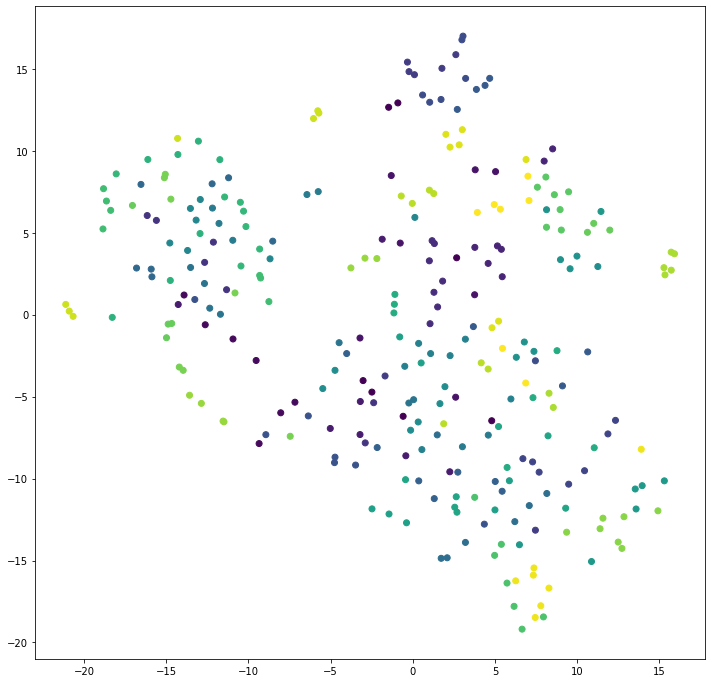

In [12]:
embeddings = base_network.predict(train_fea_reshape)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_orl_gnd.flatten());

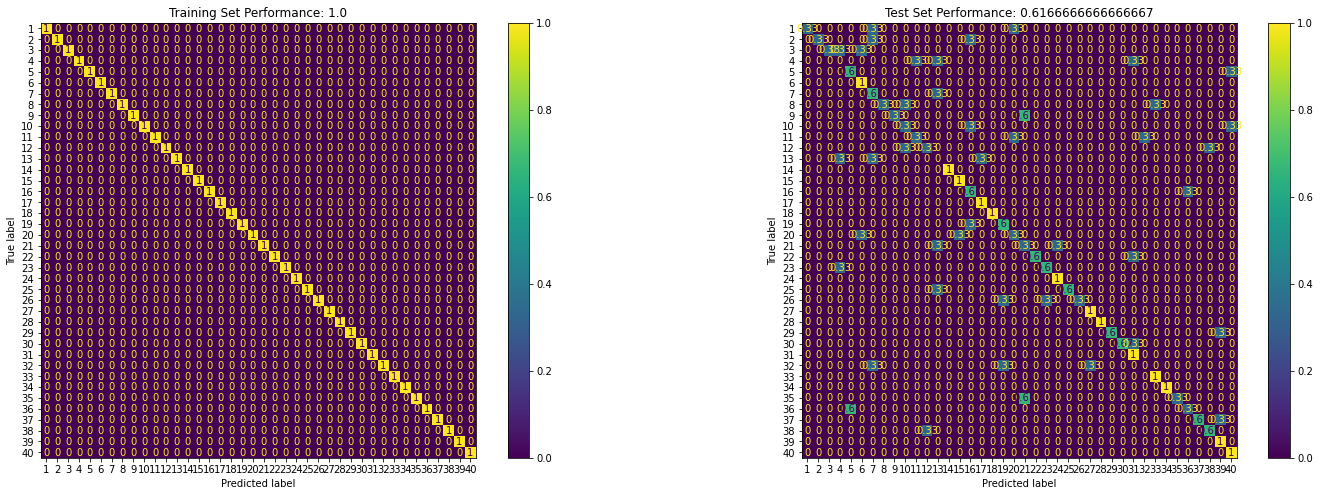

In [13]:
test_embeddings = base_network.predict(test_fea_reshape)
cknn_siam = KNeighborsClassifier(n_neighbors=3, weights='distance')
cknn_siam.fit(embeddings, train_orl_gnd)
eval_model(cknn_siam, embeddings, train_orl_gnd, test_embeddings, test_orl_gnd) 

This has actually improved a bit, and is not showing slightly better generalisation that we've seen before.

Finally, Yale.

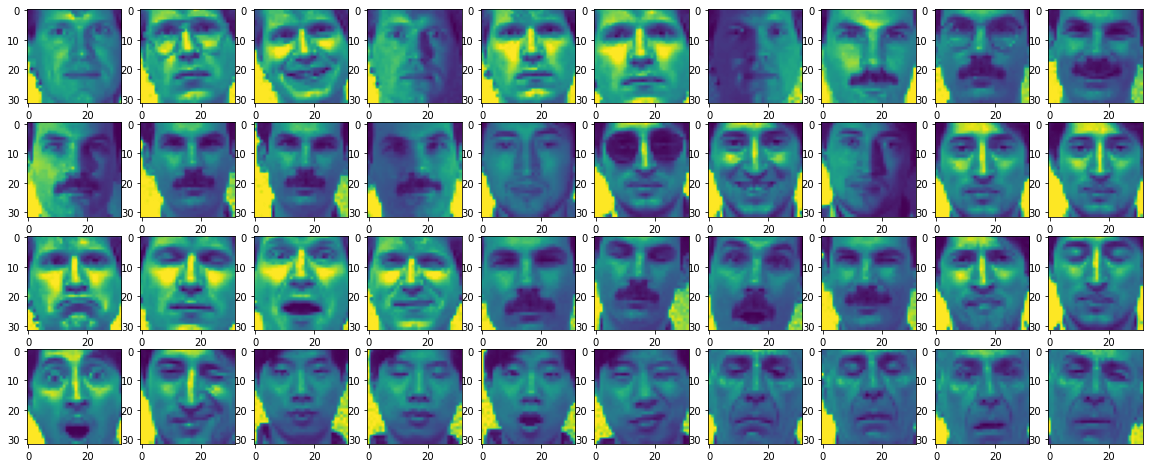

In [14]:
yale = scipy.io.loadmat('../../data/Yale_32x32.mat');
fea = yale['fea'] / 255.0
gnd = numpy.array(yale['gnd'])

train_frames = []
for i in range(15):
    for j in range(7):
        train_frames.append(i*11 + j)

train_yale_fea = fea[train_frames, :]
train_yale_gnd = gnd[train_frames, :]
test_yale_fea = fea
test_yale_gnd = gnd
test_yale_fea = numpy.delete(test_yale_fea, train_frames, 0)
test_yale_gnd = numpy.delete(test_yale_gnd, train_frames, 0)
train_yale_gnd = numpy.reshape(train_yale_gnd, -1)
test_yale_gnd = numpy.reshape(test_yale_gnd, -1)

train_fea_reshape = numpy.reshape(train_yale_fea.transpose(), (32, 32, 1, len(train_yale_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_yale_fea.transpose(), (32, 32, 1, len(test_yale_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])   

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


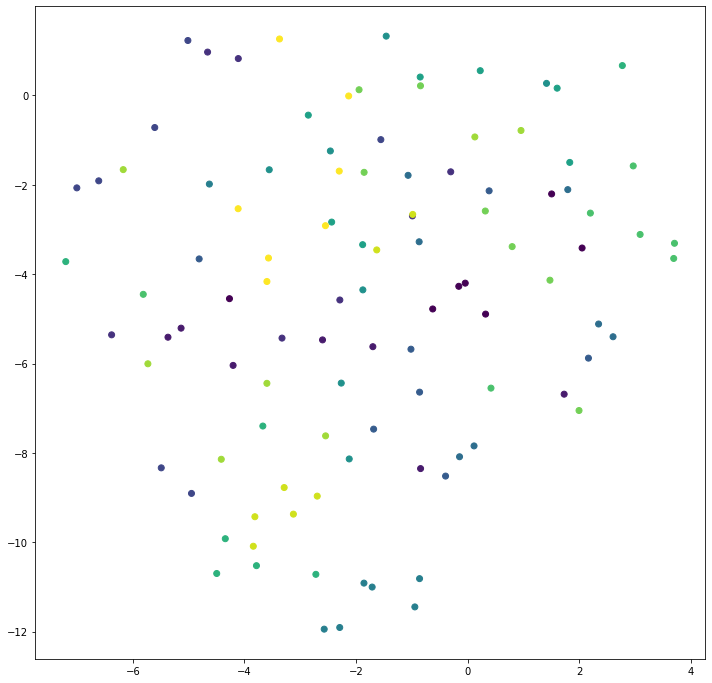

In [15]:
embeddings = base_network.predict(train_fea_reshape)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_yale_gnd.flatten());

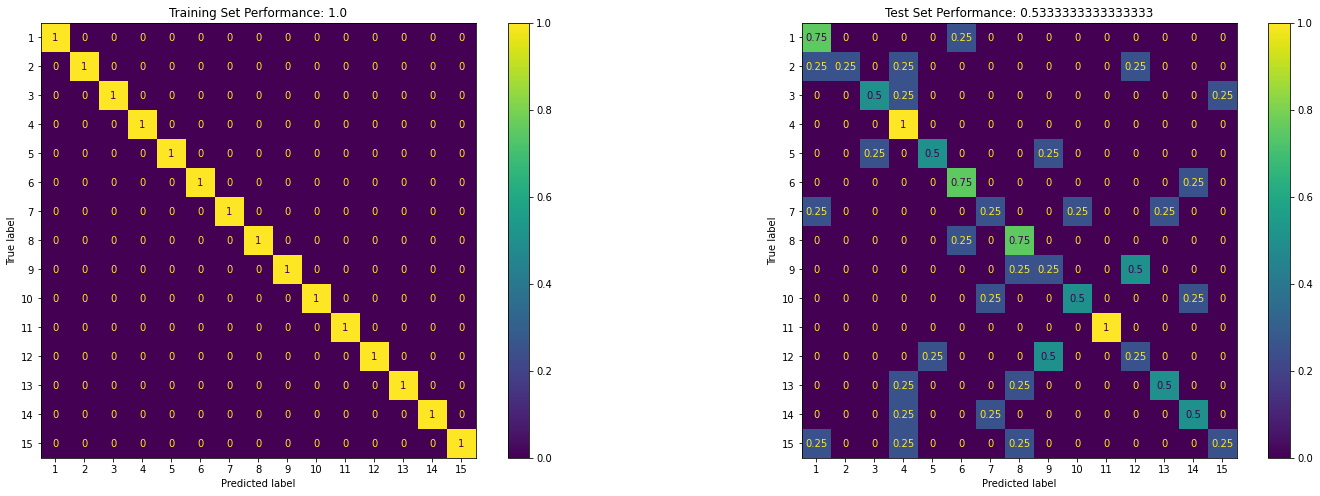

In [16]:
test_embeddings = base_network.predict(test_fea_reshape)
cknn_siam = KNeighborsClassifier(n_neighbors=3, weights='distance')
cknn_siam.fit(embeddings, train_yale_gnd)
eval_model(cknn_siam, embeddings, train_yale_gnd, test_embeddings, test_yale_gnd) 

This is also heading in the right direction. Performance is still not great, but it's been worse.

## So what have we learnt today?

In the 2a solution we finished by observing that the two tasks are really trying to do the same thing, hence we don't get a lot of gain. Here we have two very different tasks, albeit still related to one another. Our second task this time (the decoder) is trying to learn something that should generalise to other datasets. This task is not using identity information that is specific to YaleB, and so we see some gain from using this.

Our approach here is far from optimal however. Things that could be considered include:
* Our loss weights, and possibly even having these adapt as the network learns
* Our decoder structure, maybe an extra dense layer, more filters (or more conv layers)
* The decoder may be better if a different type of network (for example, a U-Net, see the week 10 lecture) was used
* We could quite easily make this semi-supervised, for example add additional face images from outside of YaleB and only do the reconstruction on them (thus avoiding annotation needs)

All of these could further improve performance to varying degrees - howeve are beyond the scope of this practical (but please, have a play with them in your own time).

There is one other big limitation that we've really ignored with this data: we don't have a lot of it. On the whole, this is a very small dataset, and this is not helping our cause. With that in mind, either using a pre-trained network and fine-tuning, or using data augmentation would also give us a boost. Note that these have both been avoided in the solutions to allow the solution and discussion to focus on the core ideas - however given the small nature of this data best practice (i.e. if this was an assignment piece, or some code that was being deployed somewhere) would mean that the small dataset size should be taken into consideration and addressed. 